In [1]:
%%capture
!pip install transformers datasets tabulate

In [2]:
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
import math
from torch.utils.data import DataLoader
from tabulate import tabulate
from datasets import load_dataset

from tqdm.notebook import tqdm
from transformers import BertTokenizer
torch.cuda.is_available()

True

This is a template of the notebook that you should complete and enrich with your own code.

First cells will be the same than the ones of the lab on text convolution.

# Data loading


In [3]:
dataset = load_dataset("scikit-learn/imdb", split="train")
print(dataset)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/1.22k [00:00<?, ?B/s]

IMDB Dataset.csv:   0%|          | 0.00/66.2M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset({
    features: ['review', 'sentiment'],
    num_rows: 50000
})


In [4]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case=True)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [5]:
def preprocessing_fn(x, tokenizer):
    x["review_ids"] = tokenizer(
        x["review"],
        add_special_tokens=False,
        truncation=True,
        max_length=256,
        padding=False,
        return_attention_mask=False,
    )["input_ids"]
    x["label"] = 0 if x["sentiment"] == "negative" else 1
    return x


In [6]:
n_samples = 10000  # the number of training example

# We first shuffle the data !
data_shuffled = dataset.shuffle()

# Select 5000 samples
data_shuffled_sampled = data_shuffled.select(range(n_samples))

# Tokenize the dataset
data_tokenized = data_shuffled_sampled.map(lambda x: preprocessing_fn(x, tokenizer))

# Remove useless columns
data_tokenized = data_tokenized.remove_columns(["review", "sentiment"])

# Split the train and validation
split = data_tokenized.train_test_split(test_size=0.2)
train_set = split['train']
valid_set = split["test"]


Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [7]:
from torch.utils.data import Dataset

class sentiment(Dataset):
    def __init__(self, review_label_set):
      self.sentences = review_label_set["review_ids"]
      self.labels = review_label_set["label"]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx: int):
        return self.sentences[idx], self.labels[idx]

In [8]:
def collate_fn(batch, max_size = 256):
    sentences_padded = []
    labels = []

    for sentence, label in batch:

        sentence_padded = [0]*max_size
        sentence_padded[:len(sentence)] = sentence
        sentences_padded.append(sentence_padded)
        labels.append(label)

    return {
        'sentences_padded': torch.tensor(sentences_padded, dtype=torch.long),
        'labels': torch.tensor(labels, dtype=torch.long),
    }

In [9]:
train_dataset = sentiment(train_set)
valid_dataset = sentiment(valid_set)

In [10]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

In [11]:
batch = next(iter(train_loader))
batch['labels'].shape

torch.Size([32])

# Model

In [15]:
class Word2Vec(nn.Module):
    def __init__(self, vocab_size, embedding_dim,device = 'cuda'):
        super(Word2Vec, self).__init__()
        self.device = device
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim).to(device)
        self.context_embeddings = nn.Embedding(vocab_size, embedding_dim).to(device)

In [18]:
vocab_size = tokenizer.vocab_size
embedding_dim = 100
word2vec = Word2Vec(vocab_size,embedding_dim).to('cuda')
word2vec.load_state_dict(torch.load("model2_dim-100_radius-10_ratio-5_batch-1024_epoch-10_samples-10000.ckpt",weights_only=True))

"""from google.colab import drive
drive.mount('/content/drive')
checkpoint_path = "/content/drive/MyDrive/model2_dim-100_radius-10_ratio-5_batch-1024_epoch-10_samples-10000.ckpt"
word2vec.load_state_dict(torch.load(checkpoint_path,weights_only=True))"""

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<All keys matched successfully>

In [ ]:
class CNNTextClassifier(nn.Module):
    def __init__(self,word2vec, vocab_size, embedding_dim, num_classes=1):
        super(CNNTextClassifier, self).__init__()

        # Embedding layer
        self.embedding = word2vec.word_embeddings
        #self.embedding.weight = nn.Parameter(embedding_matrix)
        #self.embedding.weight.requires_grad = learnable_embedding  # Do not train the embedding layer

        # First convolutional block
        self.conv1 = nn.Conv1d(in_channels=embedding_dim, out_channels=128, kernel_size=5)
        self.pool1 = nn.MaxPool1d(kernel_size=2)  # Reduce by half

        # Second convolutional block
        self.conv2 = nn.Conv1d(in_channels=128, out_channels=128, kernel_size=5)
        self.pool2 = nn.MaxPool1d(kernel_size=2)  # Reduce by half again

        # Third convolutional block (optional for deeper networks)
        self.conv3 = nn.Conv1d(in_channels=128, out_channels=128, kernel_size=5)
        self.pool3 = nn.MaxPool1d(kernel_size=2)  # Reduce further

        # Fully connected layers
        self.fc1 = nn.Linear(3584, 10)
        self.fc2 = nn.Linear(10, num_classes)

    def forward(self, x):
        # Embedding: (batch_size, sequence_length, embedding_dim)
        x = self.embedding(x)

        # Permute for Conv1D: (batch_size, embedding_dim, sequence_length)
        x = x.permute(0, 2, 1)

        # Convolutional Block 1: Conv1D + MaxPool
        x = torch.relu(self.conv1(x))
        x = self.pool1(x)              # (batch_size, 128, 126)

        # Convolutional Block 2: Conv1D + MaxPool
        x = torch.relu(self.conv2(x))
          # (batch_size, 128, 122)
        x = self.pool2(x)              # (batch_size, 128, 61)

        # Convolutional Block 3: Conv1D + MaxPool (optional)
        x = torch.relu(self.conv3(x))  # (batch_size, 128, 57)
        x = self.pool3(x)              # (batch_size, 128, 29)

        # Flatten the output for the fully connected layer
        x = x.view(x.size(0), -1)      # (batch_size, 128 * 29)
        # Fully connected layers
        x = torch.relu(self.fc1(x))    # (batch_size, 10)
        x = torch.sigmoid(self.fc2(x)) # (batch_size, num_classes)

        return x

In [ ]:
model = CNNTextClassifier(word2vec,vocab_size, embedding_dim).to('cuda')

In [ ]:
# Example: Binary cross-entropy loss for binary classification
criterion = nn.BCELoss()

# Example: Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop with accuracy tracking
num_epochs = 20

for epoch in range(num_epochs):
    # Set model to training mode
    model.train()

    running_loss = 0.0
    correct_train = 0
    total_train = 0

    # Training phase
    print("## Train",end=" ")
    for batch in tqdm(train_loader):
        texts = batch['sentences_padded'].to('cuda')
        labels = batch['labels'].to('cuda')
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(texts).squeeze(1)  # (batch_size,) after squeezing
        loss = criterion(outputs, labels.float())

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Track training loss
        running_loss += loss.item()

        # Compute training accuracy
        preds = (outputs >= 0.5).long()  # Convert probabilities to binary (0 or 1)
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

    # Compute training accuracy
    train_accuracy = correct_train / total_train

    # Validation phase
    model.eval()  # Set model to evaluation mode (no dropout, batchnorm frozen, etc.)

    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():  # No need to compute gradients during validation
        print("## Val",end=" ")
        for batch in tqdm(valid_loader):

            texts = batch['sentences_padded'].to('cuda')
            labels = batch['labels'].to('cuda')
            outputs = model(texts).squeeze(1)
            loss = criterion(outputs, labels.float())

            # Track validation loss
            val_loss += loss.item()

            # Compute validation accuracy
            preds = (outputs >= 0.5).long()  # Convert probabilities to binary (0 or 1)
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)

    # Compute validation accuracy
    val_accuracy = correct_val / total_val

    # Print epoch statistics
    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {running_loss / len(train_loader):.4f}, '
          f'Train Accuracy: {train_accuracy:.4f}, '
          f'Val Loss: {val_loss / len(valid_loader):.4f}, '
          f'Val Accuracy: {val_accuracy:.4f}')


## Train 

  0%|          | 0/250 [00:00<?, ?it/s]

## Val 

  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [1/20], Train Loss: 0.6608, Train Accuracy: 0.5760, Val Loss: 0.5012, Val Accuracy: 0.7615
## Train 

  0%|          | 0/250 [00:00<?, ?it/s]

## Val 

  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [2/20], Train Loss: 0.4049, Train Accuracy: 0.8215, Val Loss: 0.3921, Val Accuracy: 0.8260
## Train 

  0%|          | 0/250 [00:00<?, ?it/s]

## Val 

  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [3/20], Train Loss: 0.2293, Train Accuracy: 0.9115, Val Loss: 0.4000, Val Accuracy: 0.8400
## Train 

  0%|          | 0/250 [00:00<?, ?it/s]

## Val 

  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [4/20], Train Loss: 0.1372, Train Accuracy: 0.9494, Val Loss: 0.5068, Val Accuracy: 0.8205
## Train 

  0%|          | 0/250 [00:00<?, ?it/s]

## Val 

  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [5/20], Train Loss: 0.0539, Train Accuracy: 0.9824, Val Loss: 0.7097, Val Accuracy: 0.8325
## Train 

  0%|          | 0/250 [00:00<?, ?it/s]

## Val 

  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [6/20], Train Loss: 0.0258, Train Accuracy: 0.9905, Val Loss: 1.1834, Val Accuracy: 0.8130
## Train 

  0%|          | 0/250 [00:00<?, ?it/s]

## Val 

  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [7/20], Train Loss: 0.0109, Train Accuracy: 0.9962, Val Loss: 1.6247, Val Accuracy: 0.8205
## Train 

  0%|          | 0/250 [00:00<?, ?it/s]

## Val 

  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [8/20], Train Loss: 0.0199, Train Accuracy: 0.9935, Val Loss: 1.6554, Val Accuracy: 0.8200
## Train 

  0%|          | 0/250 [00:00<?, ?it/s]

## Val 

  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [9/20], Train Loss: 0.0030, Train Accuracy: 0.9994, Val Loss: 1.8681, Val Accuracy: 0.8245
## Train 

  0%|          | 0/250 [00:00<?, ?it/s]

## Val 

  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [10/20], Train Loss: 0.0004, Train Accuracy: 1.0000, Val Loss: 2.4479, Val Accuracy: 0.8210
## Train 

  0%|          | 0/250 [00:00<?, ?it/s]

## Val 

  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [11/20], Train Loss: 0.0001, Train Accuracy: 1.0000, Val Loss: 2.6568, Val Accuracy: 0.8220
## Train 

  0%|          | 0/250 [00:00<?, ?it/s]

## Val 

  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [12/20], Train Loss: 0.0000, Train Accuracy: 1.0000, Val Loss: 3.1090, Val Accuracy: 0.8190
## Train 

  0%|          | 0/250 [00:00<?, ?it/s]

## Val 

  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [13/20], Train Loss: 0.0000, Train Accuracy: 1.0000, Val Loss: 3.2229, Val Accuracy: 0.8190
## Train 

  0%|          | 0/250 [00:00<?, ?it/s]

## Val 

  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [14/20], Train Loss: 0.0000, Train Accuracy: 1.0000, Val Loss: 3.5920, Val Accuracy: 0.8200
## Train 

  0%|          | 0/250 [00:00<?, ?it/s]

## Val 

  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [15/20], Train Loss: 0.0000, Train Accuracy: 1.0000, Val Loss: 3.9096, Val Accuracy: 0.8195
## Train 

  0%|          | 0/250 [00:00<?, ?it/s]

## Val 

  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [16/20], Train Loss: 0.0000, Train Accuracy: 1.0000, Val Loss: 3.9748, Val Accuracy: 0.8215
## Train 

  0%|          | 0/250 [00:00<?, ?it/s]

## Val 

  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [17/20], Train Loss: 0.0000, Train Accuracy: 1.0000, Val Loss: 4.2295, Val Accuracy: 0.8225
## Train 

  0%|          | 0/250 [00:00<?, ?it/s]

## Val 

  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [18/20], Train Loss: 0.0000, Train Accuracy: 1.0000, Val Loss: 4.4436, Val Accuracy: 0.8205
## Train 

  0%|          | 0/250 [00:00<?, ?it/s]

## Val 

  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [19/20], Train Loss: 0.0000, Train Accuracy: 1.0000, Val Loss: 4.4519, Val Accuracy: 0.8225
## Train 

  0%|          | 0/250 [00:00<?, ?it/s]

## Val 

  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [20/20], Train Loss: 0.0000, Train Accuracy: 1.0000, Val Loss: 4.5335, Val Accuracy: 0.8220


In [21]:
class CNNTextClassifier_2(nn.Module):
    def __init__(self,word2vec, vocab_size, embedding_dim, num_classes=1, feature_size=100, kernel_size=3):
        super().__init__()

        # Embedding layer
        self.embedding = word2vec.word_embeddings
        self.feature_size = feature_size
        #self.embedding.weight = nn.Parameter(embedding_matrix)
        #self.embedding.weight.requires_grad = learnable_embedding  # Do not train the embedding layer

        # First convolutional block
        self.conv = nn.Conv1d(
            embedding_dim,
            feature_size,
            kernel_size,
            padding=math.floor(kernel_size / 2),
        )

        self.pool = nn.AdaptiveMaxPool1d(1)
        self.dropout = nn.Dropout(0.3)
        self.linear = nn.Linear(feature_size, 1)
        self.out_activation = nn.Sigmoid()

    def forward(self, x):
        # Embedding: (batch_size, sequence_length, embedding_dim)
        x = self.embedding(x)

        # Permute for Conv1D: (batch_size, embedding_dim, sequence_length)
        x = x.permute(0, 2, 1)

        # Convolutional Block 1: Conv1D + MaxPool
        x = F.relu(self.conv(x))
        x = self.pool(x)

        x = x.squeeze(dim=2)
        x = self.dropout(x)
        logits = self.linear(x)

        return self.out_activation(logits)

In [24]:
model_2 = CNNTextClassifier_2(word2vec,vocab_size, embedding_dim).to('cuda')

## Train 

  0%|          | 0/250 [00:00<?, ?it/s]

## Val 

  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [1/50], Train Loss: 0.0001, Train Accuracy: 1.0000, Val Loss: 5.5031, Val Accuracy: 0.7595
## Train 

  0%|          | 0/250 [00:00<?, ?it/s]

## Val 

  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [2/50], Train Loss: 0.0001, Train Accuracy: 1.0000, Val Loss: 5.6265, Val Accuracy: 0.7590
## Train 

  0%|          | 0/250 [00:00<?, ?it/s]

## Val 

  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [3/50], Train Loss: 0.0000, Train Accuracy: 1.0000, Val Loss: 5.3231, Val Accuracy: 0.7600
## Train 

  0%|          | 0/250 [00:00<?, ?it/s]

## Val 

  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [4/50], Train Loss: 0.0000, Train Accuracy: 1.0000, Val Loss: 5.3858, Val Accuracy: 0.7600
## Train 

  0%|          | 0/250 [00:00<?, ?it/s]

## Val 

  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [5/50], Train Loss: 0.0000, Train Accuracy: 1.0000, Val Loss: 5.4322, Val Accuracy: 0.7580
## Train 

  0%|          | 0/250 [00:00<?, ?it/s]

## Val 

  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [6/50], Train Loss: 0.0002, Train Accuracy: 0.9999, Val Loss: 5.1557, Val Accuracy: 0.7590
## Train 

  0%|          | 0/250 [00:00<?, ?it/s]

## Val 

  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [7/50], Train Loss: 0.0001, Train Accuracy: 1.0000, Val Loss: 6.1620, Val Accuracy: 0.7590
## Train 

  0%|          | 0/250 [00:00<?, ?it/s]

## Val 

  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [8/50], Train Loss: 0.0000, Train Accuracy: 1.0000, Val Loss: 5.4017, Val Accuracy: 0.7555
## Train 

  0%|          | 0/250 [00:00<?, ?it/s]

## Val 

  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [9/50], Train Loss: 0.0000, Train Accuracy: 1.0000, Val Loss: 5.8535, Val Accuracy: 0.7585
## Train 

  0%|          | 0/250 [00:00<?, ?it/s]

## Val 

  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [10/50], Train Loss: 0.0000, Train Accuracy: 1.0000, Val Loss: 5.1734, Val Accuracy: 0.7540
## Train 

  0%|          | 0/250 [00:00<?, ?it/s]

## Val 

  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [11/50], Train Loss: 0.0000, Train Accuracy: 1.0000, Val Loss: 5.3304, Val Accuracy: 0.7575
## Train 

  0%|          | 0/250 [00:00<?, ?it/s]

## Val 

  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [12/50], Train Loss: 0.0000, Train Accuracy: 1.0000, Val Loss: 7.7211, Val Accuracy: 0.7620
## Train 

  0%|          | 0/250 [00:00<?, ?it/s]

## Val 

  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [13/50], Train Loss: 0.0003, Train Accuracy: 0.9998, Val Loss: 6.4295, Val Accuracy: 0.7645
## Train 

  0%|          | 0/250 [00:00<?, ?it/s]

## Val 

  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [14/50], Train Loss: 0.0003, Train Accuracy: 0.9999, Val Loss: 5.3614, Val Accuracy: 0.7585
## Train 

  0%|          | 0/250 [00:00<?, ?it/s]

## Val 

  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [15/50], Train Loss: 0.0000, Train Accuracy: 1.0000, Val Loss: 5.3986, Val Accuracy: 0.7540
## Train 

  0%|          | 0/250 [00:00<?, ?it/s]

## Val 

  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [16/50], Train Loss: 0.0000, Train Accuracy: 1.0000, Val Loss: 5.7745, Val Accuracy: 0.7570
## Train 

  0%|          | 0/250 [00:00<?, ?it/s]

## Val 

  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [17/50], Train Loss: 0.0008, Train Accuracy: 0.9999, Val Loss: 5.3497, Val Accuracy: 0.7455
## Train 

  0%|          | 0/250 [00:00<?, ?it/s]

## Val 

  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [18/50], Train Loss: 0.0000, Train Accuracy: 1.0000, Val Loss: 5.5037, Val Accuracy: 0.7470
## Train 

  0%|          | 0/250 [00:00<?, ?it/s]

## Val 

  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [19/50], Train Loss: 0.0000, Train Accuracy: 1.0000, Val Loss: 5.9523, Val Accuracy: 0.7475
## Train 

  0%|          | 0/250 [00:00<?, ?it/s]

## Val 

  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [20/50], Train Loss: 0.0004, Train Accuracy: 0.9999, Val Loss: 6.0712, Val Accuracy: 0.7460
## Train 

  0%|          | 0/250 [00:00<?, ?it/s]

## Val 

  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [21/50], Train Loss: 0.0003, Train Accuracy: 0.9998, Val Loss: 6.3488, Val Accuracy: 0.7575
## Train 

  0%|          | 0/250 [00:00<?, ?it/s]

## Val 

  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [22/50], Train Loss: 0.0000, Train Accuracy: 1.0000, Val Loss: 5.4159, Val Accuracy: 0.7470
## Train 

  0%|          | 0/250 [00:00<?, ?it/s]

## Val 

  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [23/50], Train Loss: 0.0001, Train Accuracy: 1.0000, Val Loss: 6.2450, Val Accuracy: 0.7490
## Train 

  0%|          | 0/250 [00:00<?, ?it/s]

## Val 

  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [24/50], Train Loss: 0.0001, Train Accuracy: 1.0000, Val Loss: 5.8006, Val Accuracy: 0.7485
## Train 

  0%|          | 0/250 [00:00<?, ?it/s]

## Val 

  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [25/50], Train Loss: 0.0000, Train Accuracy: 1.0000, Val Loss: 5.8602, Val Accuracy: 0.7470
## Train 

  0%|          | 0/250 [00:00<?, ?it/s]

## Val 

  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [26/50], Train Loss: 0.0000, Train Accuracy: 1.0000, Val Loss: 6.0533, Val Accuracy: 0.7475
## Train 

  0%|          | 0/250 [00:00<?, ?it/s]

## Val 

  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [27/50], Train Loss: 0.0005, Train Accuracy: 0.9998, Val Loss: 6.1601, Val Accuracy: 0.7450
## Train 

  0%|          | 0/250 [00:00<?, ?it/s]

## Val 

  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [28/50], Train Loss: 0.0000, Train Accuracy: 1.0000, Val Loss: 6.0325, Val Accuracy: 0.7475
## Train 

  0%|          | 0/250 [00:00<?, ?it/s]

## Val 

  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [29/50], Train Loss: 0.0002, Train Accuracy: 0.9999, Val Loss: 8.5392, Val Accuracy: 0.7580
## Train 

  0%|          | 0/250 [00:00<?, ?it/s]

## Val 

  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [30/50], Train Loss: 0.0013, Train Accuracy: 0.9998, Val Loss: 6.3340, Val Accuracy: 0.7490
## Train 

  0%|          | 0/250 [00:00<?, ?it/s]

## Val 

  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [31/50], Train Loss: 0.0000, Train Accuracy: 1.0000, Val Loss: 6.0387, Val Accuracy: 0.7520
## Train 

  0%|          | 0/250 [00:00<?, ?it/s]

## Val 

  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [32/50], Train Loss: 0.0017, Train Accuracy: 0.9998, Val Loss: 5.8953, Val Accuracy: 0.7500
## Train 

  0%|          | 0/250 [00:00<?, ?it/s]

## Val 

  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [33/50], Train Loss: 0.0004, Train Accuracy: 0.9999, Val Loss: 5.1821, Val Accuracy: 0.7425
## Train 

  0%|          | 0/250 [00:00<?, ?it/s]

## Val 

  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [34/50], Train Loss: 0.0004, Train Accuracy: 0.9999, Val Loss: 5.6775, Val Accuracy: 0.7405
## Train 

  0%|          | 0/250 [00:00<?, ?it/s]

## Val 

  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [35/50], Train Loss: 0.0004, Train Accuracy: 0.9999, Val Loss: 7.1952, Val Accuracy: 0.7560
## Train 

  0%|          | 0/250 [00:00<?, ?it/s]

## Val 

  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [36/50], Train Loss: 0.0000, Train Accuracy: 1.0000, Val Loss: 6.3735, Val Accuracy: 0.7495
## Train 

  0%|          | 0/250 [00:00<?, ?it/s]

## Val 

  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [37/50], Train Loss: 0.0000, Train Accuracy: 1.0000, Val Loss: 6.2756, Val Accuracy: 0.7505
## Train 

  0%|          | 0/250 [00:00<?, ?it/s]

## Val 

  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [38/50], Train Loss: 0.0000, Train Accuracy: 1.0000, Val Loss: 6.4024, Val Accuracy: 0.7510
## Train 

  0%|          | 0/250 [00:00<?, ?it/s]

## Val 

  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [39/50], Train Loss: 0.0000, Train Accuracy: 1.0000, Val Loss: 6.3239, Val Accuracy: 0.7525
## Train 

  0%|          | 0/250 [00:00<?, ?it/s]

## Val 

  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [40/50], Train Loss: 0.0000, Train Accuracy: 1.0000, Val Loss: 6.3658, Val Accuracy: 0.7530
## Train 

  0%|          | 0/250 [00:00<?, ?it/s]

## Val 

  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [41/50], Train Loss: 0.0000, Train Accuracy: 1.0000, Val Loss: 6.2563, Val Accuracy: 0.7525
## Train 

  0%|          | 0/250 [00:00<?, ?it/s]

## Val 

  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [42/50], Train Loss: 0.0000, Train Accuracy: 1.0000, Val Loss: 6.1736, Val Accuracy: 0.7540
## Train 

  0%|          | 0/250 [00:00<?, ?it/s]

## Val 

  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [43/50], Train Loss: 0.0000, Train Accuracy: 1.0000, Val Loss: 6.1814, Val Accuracy: 0.7540
## Train 

  0%|          | 0/250 [00:00<?, ?it/s]

## Val 

  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [44/50], Train Loss: 0.0000, Train Accuracy: 1.0000, Val Loss: 6.1226, Val Accuracy: 0.7545
## Train 

  0%|          | 0/250 [00:00<?, ?it/s]

## Val 

  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [45/50], Train Loss: 0.0000, Train Accuracy: 1.0000, Val Loss: 6.0485, Val Accuracy: 0.7530
## Train 

  0%|          | 0/250 [00:00<?, ?it/s]

## Val 

  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [46/50], Train Loss: 0.0000, Train Accuracy: 1.0000, Val Loss: 5.9262, Val Accuracy: 0.7540
## Train 

  0%|          | 0/250 [00:00<?, ?it/s]

## Val 

  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [47/50], Train Loss: 0.0000, Train Accuracy: 1.0000, Val Loss: 6.2011, Val Accuracy: 0.7540
## Train 

  0%|          | 0/250 [00:00<?, ?it/s]

## Val 

  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [48/50], Train Loss: 0.0003, Train Accuracy: 0.9998, Val Loss: 6.2710, Val Accuracy: 0.7575
## Train 

  0%|          | 0/250 [00:00<?, ?it/s]

## Val 

  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [49/50], Train Loss: 0.0001, Train Accuracy: 1.0000, Val Loss: 6.0156, Val Accuracy: 0.7450
## Train 

  0%|          | 0/250 [00:00<?, ?it/s]

## Val 

  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [50/50], Train Loss: 0.0000, Train Accuracy: 1.0000, Val Loss: 6.3822, Val Accuracy: 0.7585


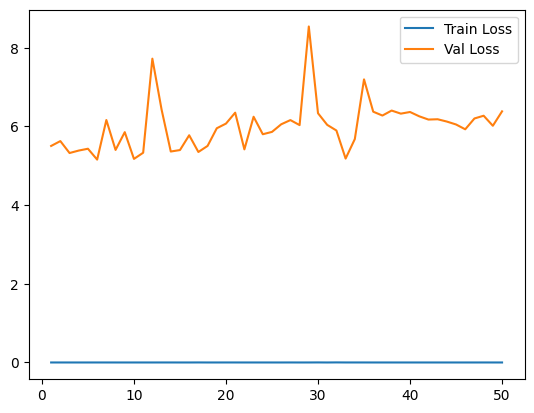

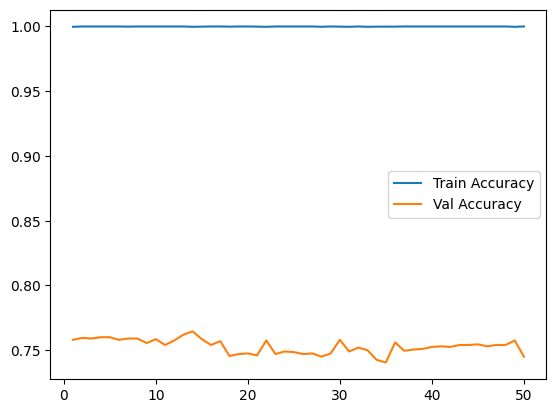

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# Example: Binary cross-entropy loss for binary classification
criterion = nn.BCELoss()

# Example: Adam optimizer
optimizer = torch.optim.Adam(model_2.parameters(), lr=0.001)

# Training loop with accuracy tracking
num_epochs = 50

avg_loss_train_list = []
avg_loss_val_list = []
avg_acc_train_list = []
avg_acc_val_list = []

for epoch in range(num_epochs):
    # Set model to training mode
    model_2.train()

    running_loss = 0.0
    correct_train = 0
    total_train = 0

    # Training phase
    print("## Train",end=" ")
    for batch in tqdm(train_loader):
        texts = batch['sentences_padded'].to('cuda')
        labels = batch['labels'].to('cuda')
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model_2(texts).squeeze(1)  # (batch_size,) after squeezing
        loss = criterion(outputs, labels.float())

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Track training loss
        running_loss += loss.item()

        # Compute training accuracy
        preds = (outputs >= 0.5).long()  # Convert probabilities to binary (0 or 1)
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)
        acc_train_list.append(correct_train / total_train)

    avg_loss_train_list.append(running_loss / len(train_loader))
    avg_acc_train_list.append(train_accuracy)

    # Compute training accuracy
    train_accuracy = correct_train / total_train

    # Validation phase
    model_2.eval()  # Set model to evaluation mode (no dropout, batchnorm frozen, etc.)

    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():  # No need to compute gradients during validation
        print("## Val",end=" ")
        for batch in tqdm(valid_loader):

            texts = batch['sentences_padded'].to('cuda')
            labels = batch['labels'].to('cuda')
            outputs = model_2(texts).squeeze(1)
            loss = criterion(outputs, labels.float())

            # Track validation loss
            val_loss += loss.item()
            loss_val_list.append(val_loss)

            # Compute validation accuracy
            preds = (outputs >= 0.5).long()  # Convert probabilities to binary (0 or 1)
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)

        avg_loss_val_list.append(val_loss / len(valid_loader))
        avg_acc_val_list.append(val_accuracy)

    # Compute validation accuracy
    val_accuracy = correct_val / total_val

    # Print epoch statistics
    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {running_loss / len(train_loader):.4f}, '
          f'Train Accuracy: {train_accuracy:.4f}, '
          f'Val Loss: {val_loss / len(valid_loader):.4f}, '
          f'Val Accuracy: {val_accuracy:.4f}')

plt.plot(np.linspace(1, 50, num=50), avg_loss_train_list, label='Train Loss')
plt.plot(np.linspace(1, 50, num=50), avg_loss_val_list, label='Val Loss')
plt.legend()
plt.show()

plt.plot(np.linspace(1, 50, num=50), avg_acc_train_list, label='Train Accuracy')
plt.plot(np.linspace(1, 50, num=50), avg_acc_val_list, label='Val Accuracy')
plt.legend()
plt.show()

